In [1]:
import numpy as np

MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(f'glove.6B.{EMBEDDING_DIM}d.txt', encoding='utf-8') as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
      for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [2]:
import pandas as pd

# prepare text samples and their labels
print('Loading in comments...')

train = pd.read_csv("Toxic_comments_data/train.csv/train.csv")
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values

Loading in comments...


In [3]:
from keras.preprocessing.text import Tokenizer

# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Using TensorFlow backend.


Found 210337 unique tokens.


In [4]:
from keras.preprocessing.sequence import pad_sequences

# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (159571, 100)


In [5]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
      if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
          # words not found in embedding index will be all zeros.
          embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [6]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM,Bidirectional, GlobalMaxPool1D


# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
# x = LSTM(15, return_sequences=True)(x)
x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
output = Dense(len(possible_labels), activation="sigmoid")(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy'],
)

print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Building model...
Instructions for updating:
Colocations handled automatically by placer.
Training model...
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 128s 1ms/step - loss: 0.1207 - accuracy: 0.9636 - val_loss: 0.0694 - val_accuracy: 0.9766TA: 4s - - ETA
Epoch 2/10
127656/127656 [==============================] - 109s 856us/step - loss: 0.0641 - accuracy: 0.9782 - val_loss: 0.0613 - val_accuracy: 0.9788oss:
Epoch 3/10
127656/127656 [==============================] - 106s 831us/step - loss: 0.0588 - accuracy: 0.9797 - val_loss: 0.0582 - val_accuracy: 0.9796
Epoch 4/10
127656/127656 [==============================] - 109s 856us/step - loss: 0.0563 - accuracy: 0.9803 - val_loss: 0.0570 - val_accuracy: 0.9800 loss: 0.0 - ETA: 0s - loss: 0.056
Epoch 5/10
127656/127656 [==============================]

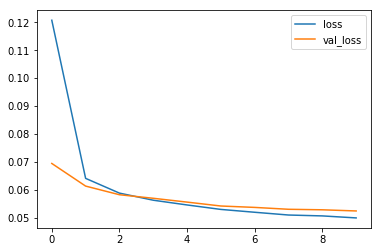

In [7]:
import matplotlib.pyplot as plt

plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

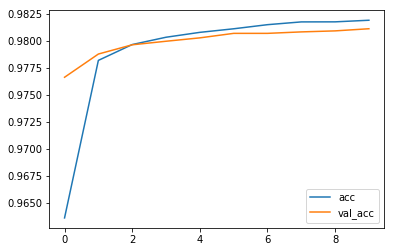

In [8]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [9]:
test = pd.read_csv("Toxic_comments_data/test.csv/test.csv")
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [10]:
test_labels = pd.read_csv("Toxic_comments_data/test_labels.csv/test_labels.csv")
test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [17]:
idx = test_labels[test_labels['toxic'] != -1].index
len(idx)

63978

In [22]:
test_with_answers = test.iloc[idx]

In [26]:
test_sequences = tokenizer.texts_to_sequences(test_with_answers['comment_text'])
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
print(test_data.shape)

(63978, 100)


In [27]:
predictions = model.predict(test_data)

In [38]:
predictions[:,0] > .5

array([False, False, False, ...,  True,  True, False])

In [35]:
test_labels[test_labels['toxic'] != -1]['toxic'].reset_index()['toxic']

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        1
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       1
25       0
26       0
27       0
28       0
29       1
        ..
63948    0
63949    0
63950    0
63951    0
63952    0
63953    0
63954    0
63955    0
63956    0
63957    0
63958    0
63959    0
63960    0
63961    0
63962    1
63963    0
63964    0
63965    0
63966    0
63967    0
63968    0
63969    0
63970    0
63971    0
63972    0
63973    0
63974    0
63975    0
63976    1
63977    0
Name: toxic, Length: 63978, dtype: int64